In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras

# Prapengolahan

In [2]:
img = cv.imread('test images\AB5592EG.jpg')
img = cv.resize(img, (int(img.shape[1]*.4),int(img.shape[0]*.4)))
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # convert bgr to grayscale
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))
img_opening = cv.morphologyEx(img_gray, cv.MORPH_OPEN, kernel)
img_norm = img_gray - img_opening

(thresh, img_norm_bw) = cv.threshold(img_norm, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
(thresh, img_without_norm_bw) = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)


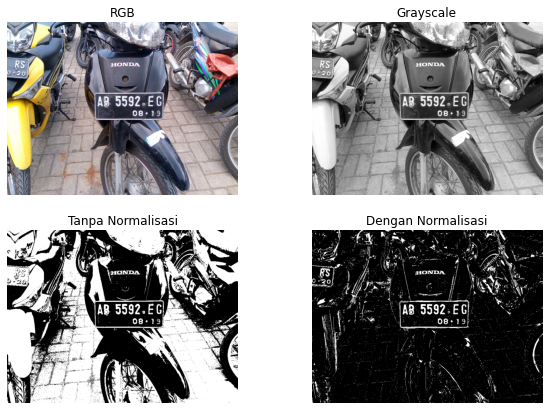

In [3]:
fig = plt.figure(figsize=(10, 7)) 
row_fig = 2
column_fig = 2

fig.add_subplot(row_fig, column_fig, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("RGB")

fig.add_subplot(row_fig, column_fig, 2)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title("Grayscale")

fig.add_subplot(row_fig, column_fig, 3)
plt.imshow(img_without_norm_bw, cmap='gray')
plt.axis('off')
plt.title("Tanpa Normalisasi")

fig.add_subplot(row_fig, column_fig, 4)
plt.imshow(img_norm_bw, cmap='gray')
plt.axis('off')
plt.title("Dengan Normalisasi")

plt.show()

# Deteksi plat


In [4]:
contours_vehicle, hierarchy = cv.findContours(img_norm_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
index_plate_candidate = []
index_counter_contour_vehicle = 0

Dapat dua lokasi plat, pilih lokasi plat kedua


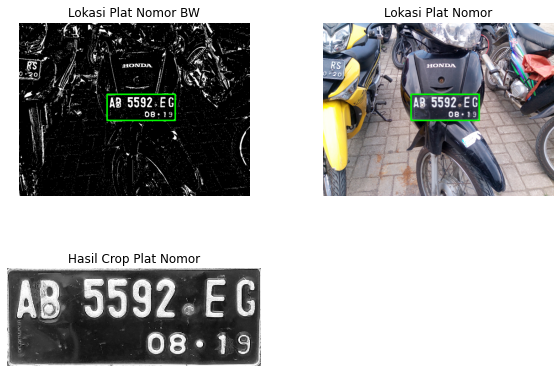

In [5]:
for contour_vehicle in contours_vehicle:
    x,y,w,h = cv.boundingRect(contour_vehicle)
    aspect_ratio = w/h
    
    if w >= 200 and aspect_ratio <= 4 : 
        index_plate_candidate.append(index_counter_contour_vehicle)
    
    index_counter_contour_vehicle += 1

img_show_plate = img.copy() 
img_show_plate_bw = cv.cvtColor(img_norm_bw, cv.COLOR_GRAY2RGB)

if len(index_plate_candidate) == 0:
    print("Plat nomor tidak ditemukan")

elif len(index_plate_candidate) == 1:
    x_plate,y_plate,w_plate,h_plate = cv.boundingRect(contours_vehicle[index_plate_candidate[0]])
    cv.rectangle(img_show_plate,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)
    cv.rectangle(img_show_plate_bw,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)
    img_plate_gray = img_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
    
else:
    print('Dapat dua lokasi plat, pilih lokasi plat kedua')

    x_plate,y_plate,w_plate,h_plate = cv.boundingRect(contours_vehicle[index_plate_candidate[1]])
    cv.rectangle(img_show_plate,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)
    cv.rectangle(img_show_plate_bw,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)
    img_plate_gray = img_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]

fig2 = plt.figure(figsize=(10, 7)) 
row_fig = 2
column_fig = 2

fig2.add_subplot(row_fig, column_fig, 1)
plt.imshow(cv.cvtColor(img_show_plate_bw, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lokasi Plat Nomor BW")

fig2.add_subplot(row_fig, column_fig, 2)
plt.imshow(cv.cvtColor(img_show_plate, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lokasi Plat Nomor")

fig2.add_subplot(row_fig, column_fig, 3)
plt.imshow(img_plate_gray, cmap="gray")
plt.axis('off')
plt.title("Hasil Crop Plat Nomor")

plt.show()


# Segmentasi Karakter

In [6]:
(thresh, img_plate_bw) = cv.threshold(img_plate_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
cv.imshow("sebelum open", img_plate_bw)

img_plate_bw = cv.morphologyEx(img_plate_bw, cv.MORPH_OPEN, kernel) # apply morph open
cv.imshow("sesudah open", img_plate_bw)

contours_plate, hierarchy = cv.findContours(img_plate_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 

index_chars_candidate = [] 
index_counter_contour_plate = 0 

img_plate_rgb = cv.cvtColor(img_plate_gray,cv.COLOR_GRAY2BGR)
img_plate_bw_rgb = cv.cvtColor(img_plate_bw, cv.COLOR_GRAY2RGB)

In [7]:
for contour_plate in contours_plate:
    x_char,y_char,w_char,h_char = cv.boundingRect(contour_plate)
    
    if h_char >= 40 and h_char <= 60 and w_char >=10:
        index_chars_candidate.append(index_counter_contour_plate)
        cv.rectangle(img_plate_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),5)
        cv.rectangle(img_plate_bw_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),5)

    index_counter_contour_plate += 1


In [8]:
if index_chars_candidate == []:
    print('Karakter tidak tersegmentasi')
else:
    score_chars_candidate = np.zeros(len(index_chars_candidate))
    counter_index_chars_candidate = 0
    
    for chars_candidateA in index_chars_candidate:
        xA,yA,wA,hA = cv.boundingRect(contours_plate[chars_candidateA])
        for chars_candidateB in index_chars_candidate:

            if chars_candidateA == chars_candidateB:
                continue
            else:
                xB,yB,wB,hB = cv.boundingRect(contours_plate[chars_candidateB])
                y_difference = abs(yA - yB)

                if y_difference < 11:
                    score_chars_candidate[counter_index_chars_candidate] = score_chars_candidate[counter_index_chars_candidate] + 1 

        counter_index_chars_candidate += 1

    print(score_chars_candidate)

    index_chars = []
    chars_counter = 0

    for score in score_chars_candidate:
        if score == max(score_chars_candidate):
            index_chars.append(index_chars_candidate[chars_counter])
        chars_counter += 1

    img_plate_rgb2 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

    for char in index_chars:
        x, y, w, h = cv.boundingRect(contours_plate[char])
        cv.rectangle(img_plate_rgb2,(x,y),(x+w,y+h),(0,255,0),5)
        cv.putText(img_plate_rgb2, str(index_chars.index(char)),(x, y + h + 50), cv.FONT_ITALIC, 2.0, (0,0,255), 3)
    
    x_coors = []

    for char in index_chars:
        x, y, w, h = cv.boundingRect(contours_plate[char])
        x_coors.append(x)

    x_coors = sorted(x_coors)
    index_chars_sorted = []

    for x_coor in x_coors:
        for char in index_chars:
            x, y, w, h = cv.boundingRect(contours_plate[char])
            
            if x_coors[x_coors.index(x_coor)] == x:
                index_chars_sorted.append(char)

    img_plate_rgb3 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

    for char_sorted in index_chars_sorted:
        x,y,w,h = cv.boundingRect(contours_plate[char_sorted])
        cv.rectangle(img_plate_rgb3,(x,y),(x+w,y+h),(0,255,0),5)
        cv.putText(img_plate_rgb3, str(index_chars_sorted.index(char_sorted)),(x, y + h + 50), cv.FONT_ITALIC, 2.0, (0,0,255), 3)
    

[7. 7. 7. 7. 7. 7. 7. 7.]


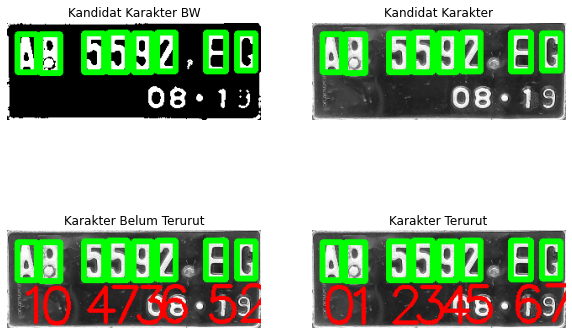

In [9]:
fig3 = plt.figure(figsize=(10, 7)) 
row_fig = 2
column_fig = 2

fig3.add_subplot(row_fig, column_fig, 1)
plt.imshow(img_plate_bw_rgb)
plt.axis('off')
plt.title("Kandidat Karakter BW")

fig3.add_subplot(row_fig, column_fig, 2)
plt.imshow(cv.cvtColor(img_plate_rgb, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Kandidat Karakter")

fig3.add_subplot(row_fig, column_fig, 3)
plt.imshow(cv.cvtColor(img_plate_rgb2, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Karakter Belum Terurut")

fig3.add_subplot(row_fig, column_fig, 4)
plt.imshow(cv.cvtColor(img_plate_rgb3, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Karakter Terurut")

plt.show()


# Klasifikasi karakter

In [10]:
    img_height = 40 
    img_width = 40

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    model = keras.models.load_model('my_model')
    num_plate = []

    for char_sorted in index_chars_sorted:
        x,y,w,h = cv.boundingRect(contours_plate[char_sorted])
        char_crop = cv.cvtColor(img_plate_bw[y:y+h,x:x+w], cv.COLOR_GRAY2BGR)
        char_crop = cv.resize(char_crop, (img_width, img_height))
        img_array = keras.preprocessing.image.img_to_array(char_crop)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0]) 

        num_plate.append(class_names[np.argmax(score)])
        print(class_names[np.argmax(score)], end='')

    plate_number = ''
    for a in num_plate:
        plate_number += a

    cv.putText(img_show_plate, plate_number,(x_plate, y_plate + h_plate + 50), cv.FONT_ITALIC, 2.0, (0,255,0), 3)
    cv.imshow(plate_number, img_show_plate)
cv.waitKey(0)

AB5582EG

-1